In [34]:
%matplotlib inline
import torch
import sys
import argparse
from torch.utils.data import DataLoader
import numpy as np
from compressai.datasets import ImageFolder
from torchvision import transforms
import matplotlib.pyplot as plt
from compressai.losses import RateDistortionLoss

from model import ELICModel
from train import AverageMeter

device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

In [35]:
def pad(img, target):
    padded = torch.zeros((1, 3, target[0], target[1])).to(device)
    padded[0, :, 0:img.shape[1], 0:img.shape[2]] = img
    return padded

def crop(img, target):
    cropped = torch.zeros((1, 3, target[0], target[1])).to(device)
    cropped[0, :, 0:target[0], 0:target[1]] = img[:target[0],:target[1]]
    return cropped

def tensor_to_rgb_img(img):
    rgb = np.moveaxis(img[0].cpu().numpy(), 0, -1)
    return rgb

torch.Size([3, 512, 512])
(512, 512, 3)


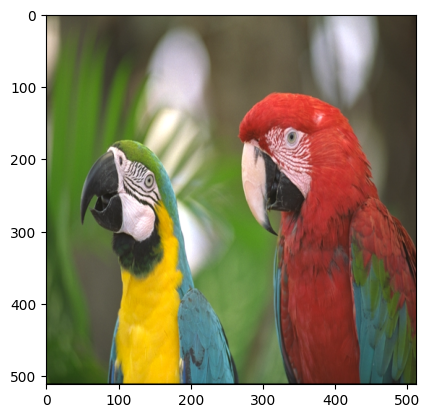

In [36]:

checkpoint = torch.load("checkpoint_best_loss.pth.tar", map_location=device)
net = ELICModel(192, 192)
net.load_state_dict(checkpoint["state_dict"])
net.update()
net.eval()
net.to(device)

test_dataset = ImageFolder("evaluation_dataset", split="test", transform=transforms.ToTensor())

img = next(iter(test_dataset))


print(img.shape)

i = tensor_to_rgb_img(img[None,:])
print(i.shape)
plt.imshow(i)

In [37]:

padded = crop(img, (512, 512))
# padded = img

print(padded.shape)
plt.figure()
rgb = tensor_to_rgb_img(padded)
print(rgb.shape)
# plt.imshow(rgb)



torch.Size([1, 3, 512, 512])
(512, 512, 3)


<Figure size 640x480 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Time diff 0.8565511703491211 0.7894418239593506
torch.Size([1, 3, 512, 512])
(512, 512, 3)


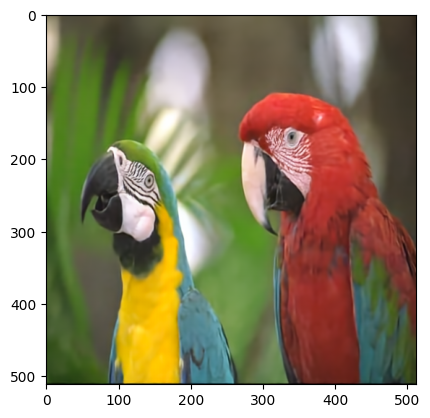

In [38]:
import time


start = time.time()
r = net.compress(padded)
mid = time.time()
y_hat = net.decompress(r['strings'],r['shape'])["x_hat"].detach()
end = time.time()
print("Time diff", mid - start, end - mid)

print(y_hat.shape)
rgb = tensor_to_rgb_img(y_hat)
print(rgb.shape)
# plt.imshow(rgb)

y_hat_sized = rgb[0:img.shape[1], 0:img.shape[2]]
plt.imshow(y_hat_sized)

In [39]:
data = r["strings"]
data_size = sum(map(len,(map(lambda x: x[0], r["strings"]))))
orginal_size = sum(img.shape)

print(f"Original size: {orginal_size}, new size: {data_size}")

Original size: 1027, new size: 17360


In [42]:
def psnr(a: np.array, b: np.array, max_val: int = 255) -> float:
    return 20 * np.log10(max_val) - 10 * np.log10(np.power((a - b), 2).mean())

print(psnr(i, rgb))

83.0212574241393


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.00057930296
0.01799917


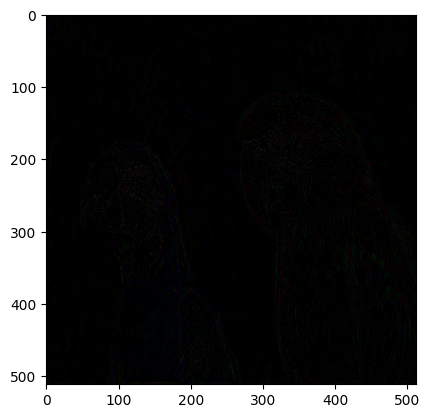

In [47]:
print((i-rgb).mean())
print((i-rgb).std())
plt.imshow(i-rgb)


In [50]:
num_pixels = 512*512
bpp = sum(len(s[0]) for s in r["strings"]) * 8.0 / num_pixels
print(bpp)

0.52978515625
